In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",999)

In [3]:
train = pd.read_csv('train.csv')
train.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [4]:
test = pd.read_csv('test.csv')

In [5]:
weather = pd.read_csv('weather.csv')

Date

In [6]:
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [7]:
weather.Date = pd.to_datetime(weather.Date)

Trying KNN without CodeSum & using Traps before location

In [8]:
weather_data = weather.drop(["SnowFall","Water1", "Depth", "WetBulb", "DewPoint", "Sunrise", "Sunset", "CodeSum"], axis=1)
weather_data["Day_of_year"] = weather_data.Date.apply(lambda c:c.dayofyear)

In [9]:
weather_data.head(2)

,Station,Date,Tmax,Tmin,Tavg,Depart,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day_of_year
0,1,2007-05-01,83,50,67,14,0,2,0.00,29.10,29.82,1.7,27,9.2,121
1,2,2007-05-01,84,52,68,M,0,3,0.00,29.18,29.82,2.7,25,9.6,121


In [10]:
def validated_value(series): #temp code
    listy = list(series)
    try: 
        validated_value = float(listy[0])
        return validated_value
    except:
        try:
            validated_value = float(listy[1])
            return validated_value
        except: 
            return listy[0]

In [11]:
weather_data_filt1 = weather_data.pivot_table(index="Date", aggfunc=validated_value)

In [12]:
weather_data_filt1[weather_data_filt1.StnPressure=="M"]

,AvgSpeed,Cool,Day_of_year,Depart,Heat,PrecipTotal,ResultDir,ResultSpeed,SeaLevel,Station,StnPressure,Tavg,Tmax,Tmin
Date,,,,,,,,,,,,,,
2013-08-10,6.5,8.0,222,0.0,0.0,0,5,5.3,30.08,1,M,73.0,81,64


_I fill in the missing value (M) looking at the trend_

In [13]:
for_obs = weather_data_filt1[(weather_data_filt1.index >= "2013") & (weather_data_filt1.index < "2014")]

[]

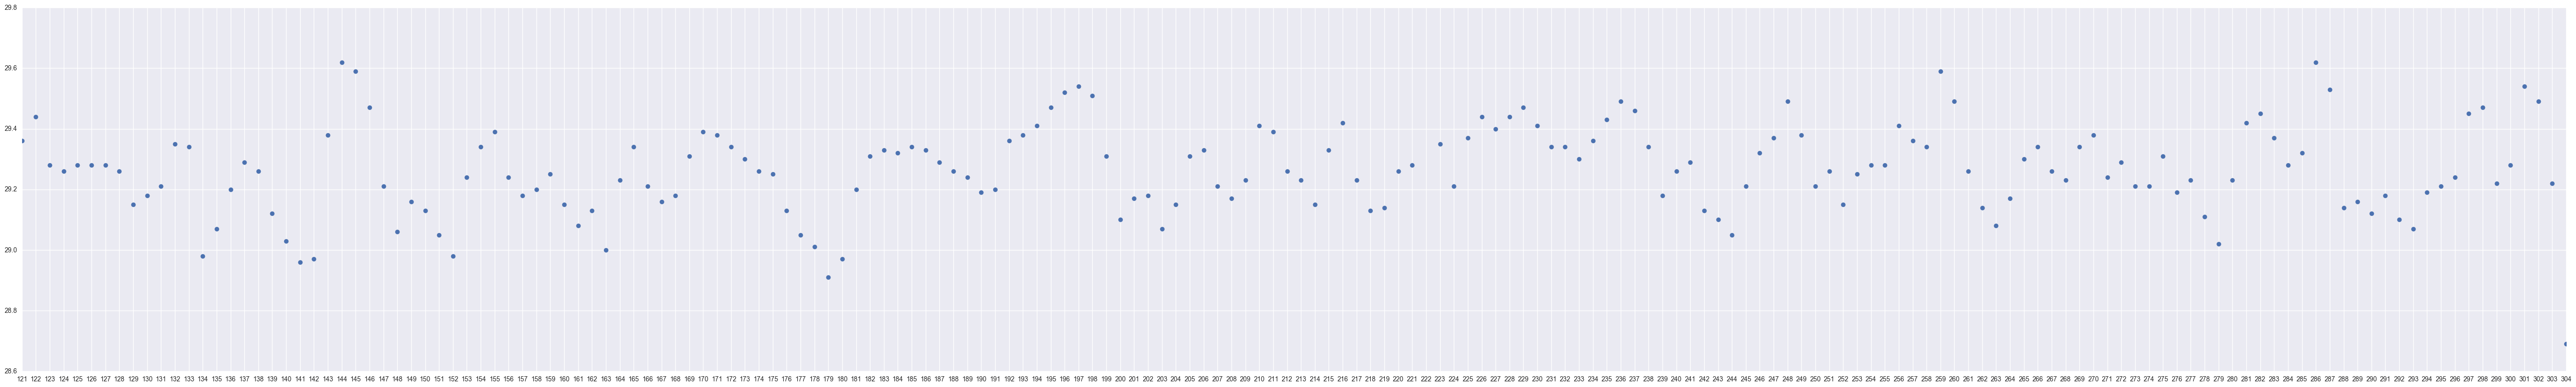

In [14]:
plt.figure(figsize=(70,10))
plt.plot_date(for_obs[for_obs.StnPressure!="M"].index, for_obs[for_obs.StnPressure!="M"].StnPressure)
plt.xticks(for_obs.index, for_obs["Day_of_year"])
plt.plot()

In [15]:
weather_data_filt1.loc["2013-08-10","StnPressure"]=29.28

In [16]:
weather_data_filt1['StnPressure']=weather_data_filt1.StnPressure.astype(float)

_Dealing with T values (T=Trace)_

In [17]:
max(weather_data_filt1[(weather_data_filt1.PrecipTotal.apply(lambda x:type(x)!=str)) &(weather_data_filt1.PrecipTotal>0)].PrecipTotal.values)

6.86

In [18]:
min(weather_data_filt1[(weather_data_filt1.PrecipTotal.apply(lambda x:type(x)!=str)) &(weather_data_filt1.PrecipTotal>0)].PrecipTotal.values)

0.01

Arbitrarily, I'll replace "Trace" with 0.001

In [19]:
for date in weather_data_filt1.index:
    if type(weather_data_filt1.loc[date,"PrecipTotal"]) != float:
        weather_data_filt1.loc[date,"PrecipTotal"]=0.001

In [20]:
weather_data_filt1["PrecipTotal"]=weather_data_filt1.PrecipTotal.astype(float)

-

In [21]:
weather_data_filt1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 14 columns):
AvgSpeed       1472 non-null float64
Cool           1472 non-null float64
Day_of_year    1472 non-null int64
Depart         1472 non-null float64
Heat           1472 non-null float64
PrecipTotal    1472 non-null float64
ResultDir      1472 non-null int64
ResultSpeed    1472 non-null float64
SeaLevel       1472 non-null float64
Station        1472 non-null int64
StnPressure    1472 non-null float64
Tavg           1472 non-null float64
Tmax           1472 non-null int64
Tmin           1472 non-null int64
dtypes: float64(9), int64(5)
memory usage: 172.5 KB


-

First Model Attempts

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [23]:
weather_data_filt1.drop("Station", axis=1, inplace=True)

In [32]:
train_and_weather = train.merge(weather_data_filt1, left_on = 'Date', right_index=True, how='inner')
test_and_weather = test.merge(weather_data_filt1, left_on = 'Date', right_index=True, how='inner')

In [25]:
train_and_weather_ = train_and_weather.drop(["AddressAccuracy","NumMosquitos","Date","Address","Block","Street","AddressNumberAndStreet"], axis=1)

In [33]:
test_and_weather_ = test_and_weather.drop(["AddressAccuracy","Date","Address","Block","Street","AddressNumberAndStreet"], axis=1)

In [26]:
train_and_weather_.head()

,Species,Trap,Latitude,Longitude,WnvPresent,AvgSpeed,Cool,Day_of_year,Depart,Heat,PrecipTotal,ResultDir,ResultSpeed,SeaLevel,StnPressure,Tavg,Tmax,Tmin
0,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,0,6.5,9.0,149,10.0,0.0,0.0,18,5.8,30.11,29.39,74.0,88,60
1,CULEX RESTUANS,T002,41.954690,-87.800991,0,6.5,9.0,149,10.0,0.0,0.0,18,5.8,30.11,29.39,74.0,88,60
2,CULEX RESTUANS,T007,41.994991,-87.769279,0,6.5,9.0,149,10.0,0.0,0.0,18,5.8,30.11,29.39,74.0,88,60
3,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,0,6.5,9.0,149,10.0,0.0,0.0,18,5.8,30.11,29.39,74.0,88,60
4,CULEX RESTUANS,T015,41.974089,-87.824812,0,6.5,9.0,149,10.0,0.0,0.0,18,5.8,30.11,29.39,74.0,88,60


First Trap & Species

In [83]:
#Scaling. (I scale by trap, but not by species due to numbers difference for rare ones)
scaler = StandardScaler().fit(train_and_weather_[(train_and_weather_.Trap=="T002")].drop(["Species",
                                                                                          "Trap",
                                                                                          "Latitude", 
                                                                                          "Longitude",
                                                                                          "WnvPresent"], axis=1))

In [84]:
first_training_data_ = train_and_weather_[(train_and_weather_.Species=="CULEX PIPIENS") 
                                          & (train_and_weather_.Trap=="T002")].copy().reset_index(drop=True)
first_training_data_.drop(["Species","Trap","Latitude", "Longitude"], axis=1, inplace=True)

In [85]:
std_Xtrain = scaler.transform(first_training_data_.drop("WnvPresent", axis=1))
#std_Xtest = scaler.transform...

y = first_training_data_['WnvPresent']

In [89]:
for max in reversed(range(1,len(y))):
    try:
        params = {'n_neighbors':range(1,max)}
        clf_knn= KNeighborsClassifier()
        clf = GridSearchCV(clf_knn, params, cv=2, scoring='roc_auc')
        model = clf.fit(std_Xtrain,y)
        break
    except:
        continue
    
print model.best_score_
print model.best_params_

0.591822094692
{'n_neighbors': 14}


Generalisation

In [27]:
train_w_preds= train_and_weather_.copy()

In [68]:
for trap in train_and_weather_["Trap"].unique():
    scaler = StandardScaler().fit(train_and_weather_[(train_and_weather_.Trap==trap)].drop(["Species",
                                                                                              "Trap",
                                                                                              "Latitude", 
                                                                                              "Longitude",
                                                                                              "WnvPresent"], axis=1))

    for species in train_and_weather_["Species"].unique():
        training_data_ = train_and_weather_[(train_and_weather_.Species==species) 
                                                  & (train_and_weather_.Trap==trap)].copy().reset_index(drop=True)
        if training_data_.shape[0]==0:
            # give prediction of 0, then
            continue
        
        else:
            training_data_.drop(["Species","Trap","Latitude", "Longitude"], axis=1, inplace=True)
     
            std_Xtrain = scaler.transform(training_data_.drop("WnvPresent", axis=1))
            #std_Xtest = scaler.transform...
            y = training_data_['WnvPresent']

            for max in reversed(range(1,len(y))):
                try:
                    params = {'n_neighbors':range(1,max)}
                    clf_knn= KNeighborsClassifier()
                    clf = GridSearchCV(clf_knn, params, cv=2, scoring='accuracy')
                    model = clf.fit(std_Xtrain,y)
                    break
                except:
                    continue

            predictions = model.predict(std_Xtrain)
            train_w_preds.loc[(train_w_preds.Species==species) 
                                                  & (train_w_preds.Trap==trap),"Pred"]=predictions


//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


Evaluating the model with the training data

In [70]:
"""train_w_preds.to_csv('train_w_AUCpreds.csv')"""

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [76]:
train_w_preds.WnvPresent.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [77]:
train_w_preds.Pred.value_counts()

0.0    10260
1.0      246
Name: Pred, dtype: int64

In [82]:
confusion_matrix(train_w_preds.WnvPresent, train_w_preds.Pred)

array([[9770,  185],
       [ 490,   61]])

In [80]:
roc_auc_score(train_w_preds.WnvPresent, train_w_preds.Pred)

0.54606208883715379

for traps not in the train document, try using KNN to replace them with the closest trap.
for UNSPECIFIED CULEX, can use boolean indexing to fill with 0 (or prior probability of the least frequent species, if I get to the probability stage...)

In [ ]:
"""obs_table = pd.DataFrame(columns = ["Trap","Species","best_score","Number_of_Neighbours"])

for trap in train_and_weather_["Trap"].unique():
    scaler = StandardScaler().fit(train_and_weather_[(train_and_weather_.Trap==trap)].drop(["Species",
                                                                                              "Trap",
                                                                                              "Latitude", 
                                                                                              "Longitude",
                                                                                              "WnvPresent"], axis=1))

    for species in train_and_weather_["Species"].unique():
        training_data_ = train_and_weather_[(train_and_weather_.Species==species) 
                                                  & (train_and_weather_.Trap==trap)].copy().reset_index(drop=True)
        training_data_.drop(["Species","Trap","Latitude", "Longitude"], axis=1, inplace=True)

        obs_table = obs_table.append({"Trap":trap, "Species":species}, ignore_index=True)
        if training_data_.shape[0]>0:
            std_Xtrain = scaler.transform(training_data_.drop("WnvPresent", axis=1))
            #std_Xtest = scaler.transform...

            y = training_data_['WnvPresent']

            for max in reversed(range(1,len(y))):
                try:
                    params = {'n_neighbors':range(1,max)}
                    clf_knn= KNeighborsClassifier()
                    clf = GridSearchCV(clf_knn, params, cv=2, scoring='roc_auc')
                    model = clf.fit(std_Xtrain,y)
                    break
                except:
                    continue

            obs_table.loc[(obs_table["Trap"]==trap) & (obs_table["Species"]==species),"best_score"]=model.best_score_
            obs_table.loc[(obs_table["Trap"]==trap) & (obs_table["Species"]==species),"Number_of_Neighbours"]=model.best_params_

        else:
            continue"""

Applying to test_data

In [54]:
for_knn_traps = train_and_weather_[["Trap", "Latitude", "Longitude"]].drop_duplicates()

In [56]:
for_knn_traps.pivot_table(index="Trap",values=["Latitude","Longitude"])

,Latitude,Longitude
Trap,,
T001,41.953705,-87.733974
T002,41.954690,-87.800991
T003,41.964242,-87.757639
T004,41.962728,-87.748367
T005,41.942114,-87.776385
T006,41.990284,-87.797127
T007,41.994991,-87.769279
T008,42.008314,-87.777921
T009,41.987221,-87.837911


In [67]:
print len(train_and_weather_.Trap.unique())
print len(for_knn_traps)

136
138


In [50]:
knn_traps = KNeighborsClassifier(n_neighbors = 1)
model = knn_traps.fit(,train["Trap"].unique()) 

TypeError: fit() takes exactly 3 arguments (2 given)

In [46]:
trap_groups = test_and_weather_[["Trap", "Latitude", "Longitude"]].groupby(by="Trap")
for trap in list(set(train.Trap).symmetric_difference(set(test.Trap))):
    pred = model.predict(trap_groups.get_group(trap)[['Latitude','Longitude']])

In [35]:
test_w_preds= test_and_weather_.copy()

In [36]:
test_w_preds.head()

,Id,Species,Trap,Latitude,Longitude,AvgSpeed,Cool,Day_of_year,Depart,Heat,PrecipTotal,ResultDir,ResultSpeed,SeaLevel,StnPressure,Tavg,Tmax,Tmin
0,1,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,10.0,9.0,163,7.0,0.0,0.0,18,8.9,29.99,29.28,74.0,86,61
1,2,CULEX RESTUANS,T002,41.95469,-87.800991,10.0,9.0,163,7.0,0.0,0.0,18,8.9,29.99,29.28,74.0,86,61
2,3,CULEX PIPIENS,T002,41.95469,-87.800991,10.0,9.0,163,7.0,0.0,0.0,18,8.9,29.99,29.28,74.0,86,61
3,4,CULEX SALINARIUS,T002,41.95469,-87.800991,10.0,9.0,163,7.0,0.0,0.0,18,8.9,29.99,29.28,74.0,86,61
4,5,CULEX TERRITANS,T002,41.95469,-87.800991,10.0,9.0,163,7.0,0.0,0.0,18,8.9,29.99,29.28,74.0,86,61


In [ ]:
"""init_pred_knn = model_knn.predict(X_test[X_test.Species==])"""

In [ ]:
"""submission = pd.DataFrame({'Id':test.Id,'WnvPresent':test.})
submission.to_csv('init_sub.csv',index=False)"""